In [2]:
### IMPORTS ###
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random

## Data Processing

In [3]:
### LOAD AND PREPARE DATA ###

#Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


#Vectorize images
x_train = np.array([np.float64(x.flatten()) for x in x_train])
x_test = np.array([np.float64(x.flatten()) for x in x_test])


#Normalize images
x_train -= np.mean(x_train, axis = 0)
x_train /= np.std(x_train, axis = 0)
x_test -= np.mean(np.float64(x_test), axis = 0)
x_test /= np.std(x_test, axis = 0)

#One hot encoding of labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)


#Insert '1' for bias
x_train = np.insert(x_train, 0, [1] * len(x_train), axis=1)
x_test = np.insert(x_test, 0, [1] * len(x_test), axis=1)


print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

170498071/170498071 [==============================] - 11s 0us/step
Train: X=(50000, 3073), y=(50000, 10)
Test: X=(10000, 3073), y=(10000, 10)


# MultiLayer Perceptron Implementation

In [30]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class MultiLayerPerceptron:

  def __init__(self, activation_function, num_hidden_layers, hidden_layers_width):
    self.activation_function = activation_function
    self.num_hidden_layers = num_hidden_layers
    self.hidden_layers_width = hidden_layers_width
    self.loss_per_epoch = []


    #Initialize weights with given number of hidden layers (0, 1 or 2)
    if num_hidden_layers == 0:
      self.w1 = np.random.rand(10, 3073)/1000

    elif num_hidden_layers == 1:
      if len(hidden_layers_width) != 1:
        raise Exception("Invalid input: len(hidden_layers_width) != num_hidden_layers")
      self.w1 = np.random.rand(hidden_layers_width[0], 3073)/100
      self.w2 = np.random.rand(10, hidden_layers_width[0])/100

    elif num_hidden_layers == 2:
      if len(hidden_layers_width) != 2:
        raise Exception("Invalid input: len(hidden_layers_width) != num_hidden_layers")
      self.w1 = np.random.rand(hidden_layers_width[0], 3073)/1000
      self.w2 = np.random.rand(hidden_layers_width[1], hidden_layers_width[0])/1000
      self.w3 = np.random.rand(10, hidden_layers_width[1])/1000
    else:
      raise Exception("Unsupported number of hidden layers")


  def fit(self, x, y, learning_rate, epsilon, max_iters, batch_size):

    num_of_batches = int(len(x)/batch_size)
    x_batches = np.array_split(x, num_of_batches)
    y_batches = np.array_split(y, num_of_batches)

    #Gradient descent
    norms = np.array([np.inf])
    t = 0
    print("Epochs: ")
    
    #RELU WITH 0 HIDDEN LAYERS
    if self.activation_function == self.relu and self.num_hidden_layers == 0:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad = self.relu_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad #* (1/num_of_batches)
          t += 1
          norms = np.array([np.linalg.norm(g) for g in grad])
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")
      return

    #RELU WITH 1 HIDDEN LAYERS
    elif self.activation_function == self.relu and self.num_hidden_layers == 1:
      while t < max_iters:
          for batch in range(num_of_batches):
            grad_w1, grad_w2 = self.relu_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad_w1 #* (1/num_of_batches)
            self.w2 -= learning_rate * grad_w2 #* (1/num_of_batches)
          t += 1
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")
      return

    #RELU WITH 2 HIDDEN LAYERS
    elif self.activation_function == self.relu and self.num_hidden_layers == 2:
      while t < max_iters:
          for batch in range(num_of_batches):
            grad_w1, grad_w2, grad_w3 = self.relu_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad_w1 #* (1/num_of_batches)
            self.w2 -= learning_rate * grad_w2 #* (1/num_of_batches)
            self.w3 -= learning_rate * grad_w3 #* (1/num_of_batches)
          t += 1
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")
      return

    
    #TAN_H WITH 0 HIDDEN LAYERS
    if self.activation_function == self.tanh and self.num_hidden_layers == 0:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad = self.tanh_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad * (1/num_of_batches)
          t += 1
          norms = np.array([np.linalg.norm(g) for g in grad])
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")
      return

    #TAN_H WITH 1 HIDDEN LAYERS
    if self.activation_function == self.tanh and self.num_hidden_layers == 1:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad_w1, grad_w2 = self.tanh_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad_w1 * (1/num_of_batches)
            self.w2 -= learning_rate * grad_w2 * (1/num_of_batches)
          t += 1
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")
      return

    #TAN_H WITH 2 HIDDEN LAYERS
    if self.activation_function == self.tanh and self.num_hidden_layers == 2:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad_w1, grad_w2, grad_w3 = self.tanh_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad_w1 * (1/num_of_batches)
            self.w2 -= learning_rate * grad_w2 * (1/num_of_batches)
            self.w3 -= learning_rate * grad_w3 * (1/num_of_batches)
          t += 1
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")
      return


  def relu_gradient(self, x, y):

    y_hat = self.predict(x)
    self.loss_per_epoch.append(MultiLayerPerceptron.total_loss(y, y_hat))
    N, D = x.shape

    if self.num_hidden_layers == 0:
      dy = y_hat - y
      dw1 = np.matmul(np.transpose(dy), x)
      return dw1

    elif self.num_hidden_layers == 1:
      dy = y_hat - y
      dw = (np.dot(self.z1_for_gradient, dy) / N).T
      dz = np.dot(dy, self.w2)
      dv = (np.dot(x.T, dz * (self.q1_for_gradient > 0).astype(int).T) / N).T
      return dv, dw
    elif self.num_hidden_layers == 2:
      dy = y_hat - y
      dw3 = (np.dot(self.z2_for_gradient, dy) / N).T
      dz2 = np.dot(dy, self.w3)
      dw2 = ((np.dot(self.z1_for_gradient, dz2 * (self.q2_for_gradient > 0).astype(int).T)) / N).T
      dz1 = np.dot(dz2 * (1 - (self.z2_for_gradient.T)**2), self.w2)
      dw1 = ((np.dot(x.T, dz1 * (self.q1_for_gradient > 0).astype(int).T)) / N).T
      return dw1, dw2, dw3



  def tanh_gradient(self, x, y):
    y_hat = self.predict(x)
    self.loss_per_epoch.append(MultiLayerPerceptron.total_loss(y, y_hat))
    N, D = x.shape

    if self.num_hidden_layers == 0:
      dy = y_hat - y
      dw1 = np.matmul(np.transpose(dy), x)
      return dw1

    elif self.num_hidden_layers == 1:
      dy = y_hat - y
      dw = (np.dot(self.z1_for_gradient, dy) / N).T
      dz = np.dot(dy, self.w2)
      dv = (np.dot(x.T, dz * (1 - (self.z1_for_gradient.T)**2)) / N).T
      return dv, dw

    elif self.num_hidden_layers == 2:
      dy = y_hat - y
      dw3 = (np.dot(self.z2_for_gradient, dy) / N).T
      dz2 = np.dot(dy, self.w3)
      dw2 = (np.dot(self.z1_for_gradient, dz2 * (1 - (self.z2_for_gradient.T)**2)) / N).T
      dz1 = np.dot(dz2 * (1 - (self.z2_for_gradient.T)**2), self.w2)
      dw1 = ((np.dot(x.T, dz1 * (1 - (self.z1_for_gradient.T)**2))) / N).T
      return dw1, dw2, dw3


  def predict(self, x):

    if self.num_hidden_layers == 0:
      return self.softmax(np.transpose(np.dot(self.w1, np.transpose(x))))

    elif self.num_hidden_layers == 1:
      q1 = np.dot(self.w1, np.transpose(x))
      z1 = self.activation_function(q1)
      self.q1_for_gradient = q1
      self.z1_for_gradient = z1
      return self.softmax(np.transpose(np.dot(self.w2, z1)))
    else:
      q1 = np.dot(self.w1, np.transpose(x))
      z1 = self.activation_function(q1)
      self.q1_for_gradient = q1
      self.z1_for_gradient = z1
      q2 = np.matmul(self.w2, z1)
      z2 = self.activation_function(q2)
      self.q2_for_gradient = q1
      self.z2_for_gradient = z1
      return self.softmax(np.transpose(np.matmul(self.w3, z2)))

  
  @staticmethod
  def relu(x):
    return (x + np.abs(x))/2

  @staticmethod
  def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

  @staticmethod
  def softmax(x):
    R, C = x.shape
    for i in range(R):
      if max(x[i]) > 709:
        for j in range(C):
          x[i][j] = np.exp(x[i][j])/denominator
        highest_idx = np.argmax(x[i])
        x[i][highest_idx] = 1
        continue


      denominator = sum([np.exp(j) for j in x[i]])
      denominator = denominator if denominator > 0 else 1
      for j in range(C):
        x[i][j] = np.exp(x[i][j])/denominator
    return x

  @staticmethod
  def accuracy(y, y_hat):

    accurate_classifications = 0

    for i, y in enumerate(y):
      category = np.argmax(y)
      predicted_category = np.argmax(y_hat[i])

      if category == predicted_category:
        accurate_classifications += 1

    return accurate_classifications/len(y_hat)

  @staticmethod
  def total_loss(y, y_hat):

    loss = 0

    for i, y in enumerate(y):
      category = np.argmax(y)
      predicted_value = y_hat[i][category]
      loss += (-1 * np.log(predicted_value))

    return loss



In [25]:
np.exp(709)

8.218407461554972e+307

In [ ]:
shuffle = list(zip(x_train, y_train))
random.shuffle(shuffle)
x_train, y_train = zip(*shuffle)
num_train = 300


mlp = MultiLayerPerceptron(MultiLayerPerceptron.relu, 2, [256, 256])

preds = mlp.predict(x_train[:num_train])
print("Initial Accuracy: ", MultiLayerPerceptron.accuracy(y_train[:num_train], preds)*100, "%")

mlp.fit(x_train[:num_train], y_train[:num_train], learning_rate=0.0004, epsilon=0.0000001, max_iters=1000, batch_size=100)

preds = mlp.predict(x_train[:num_train])
print("Final Accuracy: ", MultiLayerPerceptron.accuracy(y_train[:num_train], preds)*100, "%")

plt.plot(range(len(mlp.loss_per_epoch)), mlp.loss_per_epoch)
plt.show()

In [6]:
### WORKS WELL ###


###1 layer tanh:
# mlp.fit(x_train[:num_train], y_train[:num_train], learning_rate=0.01, epsilon=0.0000001, max_iters=2000, batch_size=100)
# mlp.fit(x_train[:num_train], y_train[:num_train], learning_rate=0.05, epsilon=0.0000001, max_iters=1000, batch_size=1000)

###2 layer tanh:
#mlp.fit(x_train[:num_train], y_train[:num_train], learning_rate=0.1, epsilon=0.0000001, max_iters=3000, batch_size=100)


###1 layer relu:
#mlp.fit(x_train[:num_train], y_train[:num_train], learning_rate=0.006, epsilon=0.0000001, max_iters=3000, batch_size=20)



# Experiments

In [40]:
### SHUFFLE ###
shuffle = list(zip(x_train, y_train))
random.shuffle(shuffle)
x_train, y_train = zip(*shuffle)

shuffle = list(zip(x_test, y_test))
random.shuffle(shuffle)
x_test, y_test = zip(*shuffle)

## Experiment 1

In [74]:
### 0 HIDDEN-LAYER TRAINING ###
mlp_0 = MultiLayerPerceptron(MultiLayerPerceptron.relu, 0, [])
mlp_0.fit(x_train, y_train, learning_rate=0.0000001, epsilon=0.0000001, max_iters=20, batch_size=1000)

Epochs: 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
20 iterations performed


In [77]:
### 1 HIDDEN-LAYER TRAINING ###
mlp_0 = MultiLayerPerceptron(MultiLayerPerceptron.relu, 1, [256])
mlp_0.fit(x_train, y_train, learning_rate=0.0000001, epsilon=0.006, max_iters=20, batch_size=1000)

Epochs: 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
20 iterations performed


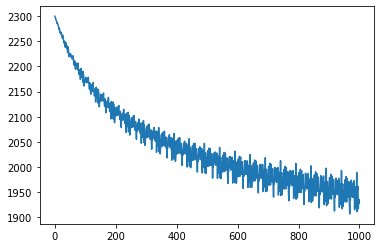

In [75]:
plt.plot(range(len(mlp_0.loss_per_epoch)), mlp_0.loss_per_epoch)
plt.show()

In [76]:
preds_train = mlp_0.predict(x_train)
preds_test = mlp_0.predict(x_test)
print("0 Hidden-Layer Training Accuracy: ", MultiLayerPerceptron.accuracy(y_train, preds_train)*100, "%")
print("0 Hidden-Layer Test Accuracy: ", MultiLayerPerceptron.accuracy(y_test, preds_test)*100, "%")

0 Hidden-Layer Training Accuracy:  33.662 %
0 Hidden-Layer Test Accuracy:  33.6 %
